Importing libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import recall_score, precision_score, f1_score, silhouette_score

Reading files

In [130]:
# Clase contains which type of tissue is each
X = pd.read_csv('datasets/dataset_tissue.txt', index_col = 0).T
y = pd.read_csv('datasets/clase.txt', index_col = 0)

There is no need of using pipelines in this case, so it is scaled the data as first step

In [131]:
X_sc = MinMaxScaler().fit_transform(X)

It has to be known the appropiate number of components which are employed to perform PCA algorythm

In [132]:
# declaring and pca instance
pca_all = PCA(n_components = X.shape[0], random_state = 23)

# fitting pipeline
pca_all.fit(X_sc)

PCA(n_components=189, random_state=23)

Plotting cumulative variance ratio

Number of components: 60


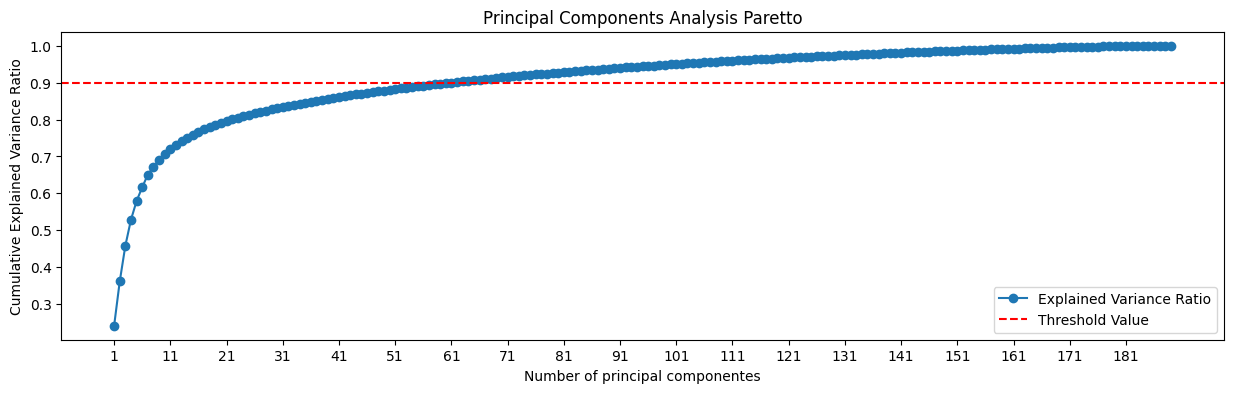

In [133]:
# getting cumulative variance
cum_variance = np.cumsum(pca_all.explained_variance_ratio_)

# choosing threshold
threshold = 0.90

# Calculating the selected number of components by using the chosen threshold
n_pca = len(cum_variance[cum_variance <= threshold])
print(f"Number of components: {n_pca}")

# defining plot
plt.figure(figsize = (15, 4))
plt.plot(cum_variance, '-o', label = 'Explained Variance Ratio')
plt.title('Principal Components Analysis Paretto')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Number of principal componentes')
plt.xticks(range(0, X.shape[0], 10), range(1, X.shape[0] + 1, 10))
plt.axhline(threshold, c = 'red', label = 'Threshold Value', linestyle = '--')
plt.legend()
plt.show()


Then the new X dataset is fitted by using the found n_components

In [134]:
# declaring and pca instance
pca = PCA(n_components = n_pca, random_state = 23)

# fitting model
X_pca = pca.fit_transform(X_sc)

Applying Agglomerative Hierarchical Clustering on those selected principal components

In [135]:
# declaring hierarchical clustering instance
agg_clus = AgglomerativeClustering(n_clusters = None, distance_threshold = 0)

# fitting model
agg_clus.fit(X_pca)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Defining function to plot dendrogram

In [136]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Plotting dendrogram

Number of Unique Variables of each type: 7


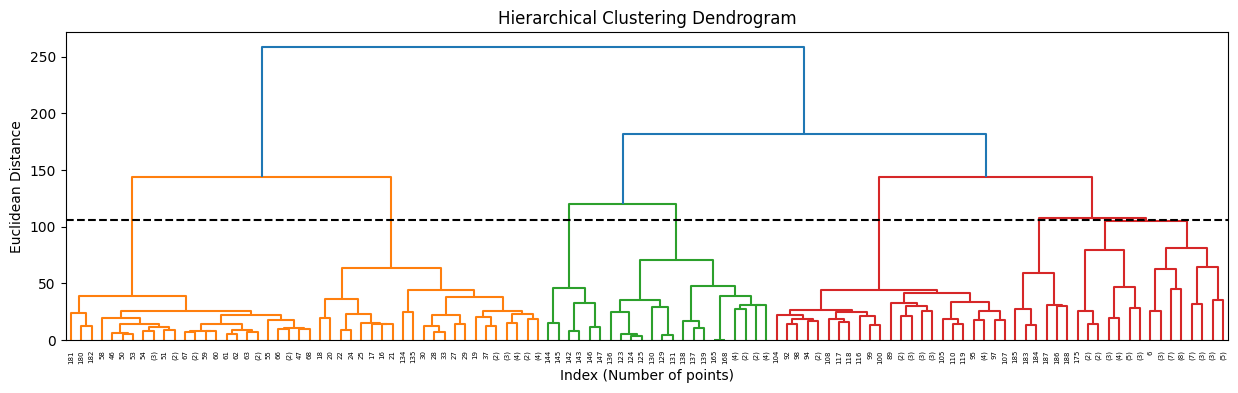

In [137]:
# defining plot
threshold_line_cut = 106
plt.figure(figsize = (15, 4))
top_n_levels_dendrogram = len(np.unique(y))
print(f"Number of Unique Variables of each type: {top_n_levels_dendrogram}")
plot_dendrogram(agg_clus, truncate_mode = 'level', p = top_n_levels_dendrogram)
plt.axhline(threshold_line_cut, c = 'black', linestyle = '--')
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Index (Number of points)')
plt.show()

It can be seen in the previous Figure, by cutting the Hierarchical Dendrogram at 106 Euclidian Distance, it is obtained 7 clusters which corresponds to the number of unique variable of "y" dataset. Now, a kind of elbow plot is made in order to verify these clusters

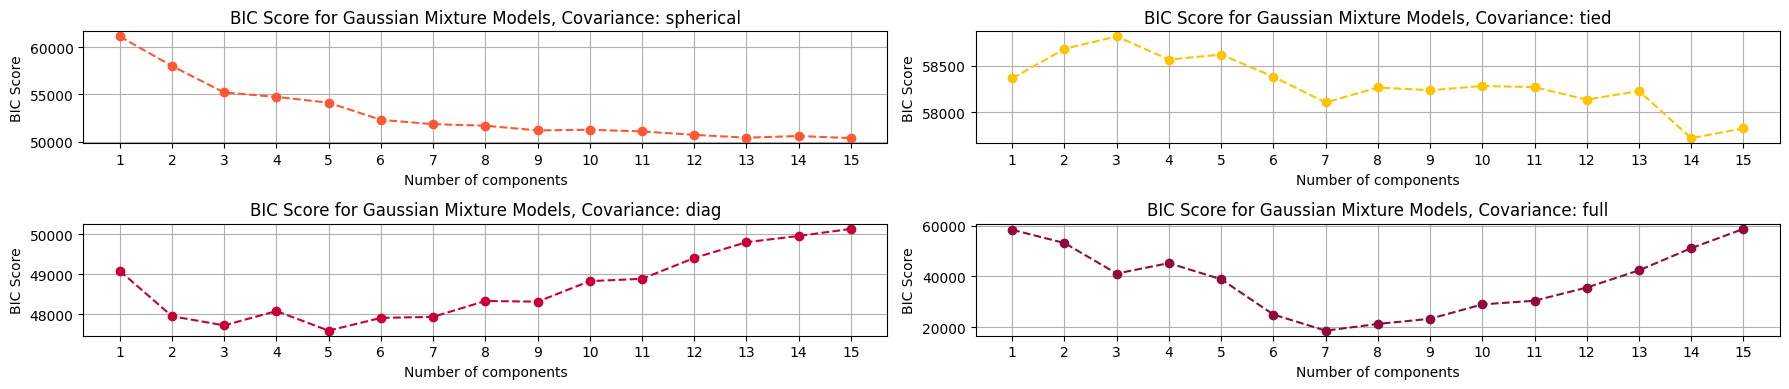

In [138]:
# declaring a dictionary to store bics per covariance type
bic_per_type = dict()

# params to test
n_max_clusters = 15
covariance_types = ['spherical', 'tied', 'diag', 'full']

# iterating the number of clusters in a mixture gaussian instance
for covariance_type in covariance_types:
    # declaring an empty list which stores each inertia per number of clusters
    bic_scores = list()
    for n_clusters in range(1, n_max_clusters + 1):
        # declaring and fitting gaussian mixture model
        gaussian_model = GaussianMixture(n_components = n_clusters, covariance_type = covariance_type, 
                                        init_params = 'k-means++', random_state = 23)
        gaussian_model.fit(X_pca)
        bic_scores.append(gaussian_model.bic(X_pca))
    # storing bic types
    bic_per_type[covariance_type] = bic_scores

# defining positions for covariances types and colors
plots_dict = dict(enumerate(covariance_types))
gauss_colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F"]

# getting the number of components per covariance type which contains the lowest bic
n_components_bic = {key: (min(enumerate(bic_per_type[key]), key = lambda x: x[1])[0] + 1, min(bic_per_type[key]))
                                for key in covariance_types}

# plotting BIC Scores
fig, axis = plt.subplots(2, 2, figsize = (18,4))

for key, data in plots_dict.items():
    row = key // 2
    col = key % 2
    ax = axis[row, col]
    ax.plot(bic_per_type[data], marker = 'o', linestyle = '--', color = gauss_colors[key])
    ax.set_xlabel('Number of components')
    ax.set_xticks(range(0, n_max_clusters), range(1, n_max_clusters + 1))
    ax.set_ylabel('BIC Score')
    ax.set_title(f'BIC Score for Gaussian Mixture Models, Covariance: {data}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Another way to test the n_components performance is by selecting the best silhouette score, the following cells shows the evaluation in terms of it

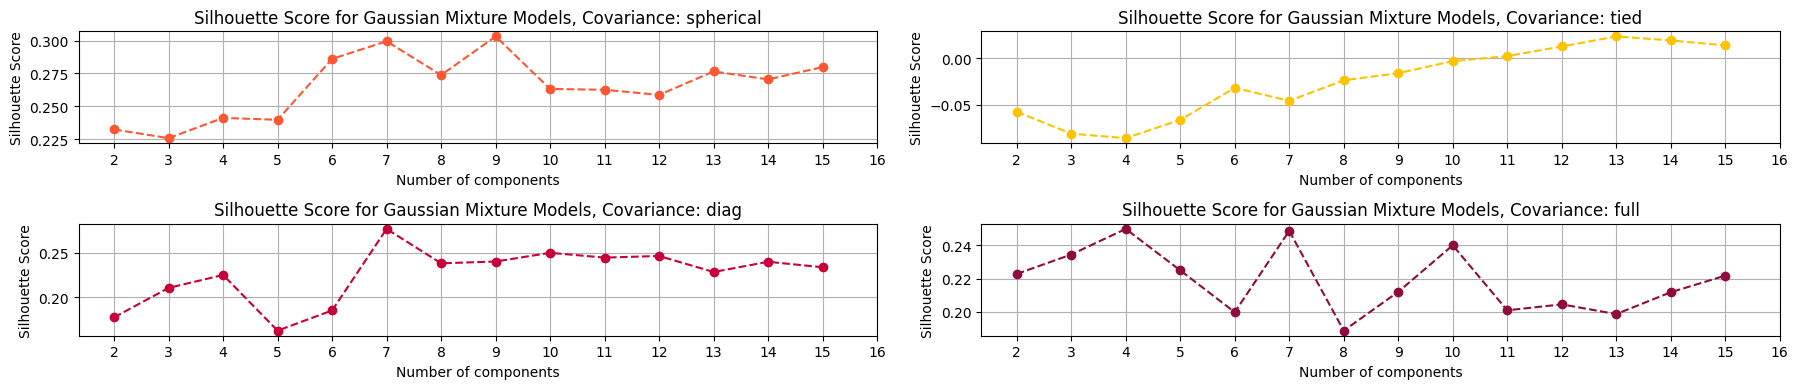

In [139]:
# declaring a dictionary to store bics per covariance type
silhouette_per_type = dict()

# params to test
n_max_clusters = 15
covariance_types = ['spherical', 'tied', 'diag', 'full']

# iterating the number of clusters in a mixture gaussian instance
for covariance_type in covariance_types:
    # declaring an empty list which stores each inertia per number of clusters
    silhouette_scores = list()
    for n_clusters in range(2, n_max_clusters + 1):
        # declaring and fitting gaussian mixture model
        gaussian_model = GaussianMixture(n_components = n_clusters, covariance_type = covariance_type, 
                                        init_params = 'k-means++', random_state = 23)
        gaussian_model.fit(X_pca)
        silhouette_scores.append(silhouette_score(X_pca, gaussian_model.predict(X_pca)))
    # storing bic types
    silhouette_per_type[covariance_type] = silhouette_scores

# defining positions for covariances types and colors
plots_dict = dict(enumerate(covariance_types))
gauss_colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F"]

# getting the number of components per covariance type which contains the highest silhouette score
n_components_sil = {key: (max(enumerate(silhouette_per_type[key]), key = lambda x: x[1])[0] + 2, max(silhouette_per_type[key]))
                                for key in covariance_types}

# plotting BIC Scores
fig, axis = plt.subplots(2, 2, figsize = (18,4))

for key, data in plots_dict.items():
    row = key // 2
    col = key % 2
    ax = axis[row, col]
    ax.plot(silhouette_per_type[data], marker = 'o', linestyle = '--', color = gauss_colors[key])
    ax.set_xlabel('Number of components')
    ax.set_xticks(range(0, n_max_clusters), range(2, n_max_clusters + 2))
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Silhouette Score for Gaussian Mixture Models, Covariance: {data}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Showing the lowest BIC and the highest Silhouette score per covariance type and select the minimum , maximum one

In [159]:
bic_summary = pd.DataFrame(n_components_bic).T.rename(columns = {0: 'n_components_bic', 1: 'bic_score'})
sil_summary = pd.DataFrame(n_components_sil).T.rename(columns = {0: 'n_components_sil', 1: 'sil_score'})
result_summary = pd.concat([bic_summary, sil_summary], axis = 1)
display(result_summary)

,n_components_bic,bic_score,n_components_sil,sil_score
spherical,15.0,50362.522726,9.0,0.303196
tied,14.0,57723.222758,13.0,0.023341
diag,5.0,47595.122741,7.0,0.277081
full,7.0,18694.801730,4.0,0.249914


As it can be observed in the plot, the lowest BIC score corresponds to a 7th-cluster-full-gaussian mixture model and the highest silhoutte to a 9th-cluster-spherical-gaussian one, this makes sense regarding the previous hierarchical plot, which showed below the threshold that there were more divisions that could have been made by decreasing this value. Now, in order to select one of them, it is compared both metrics for both cases, then it is selected one

In [176]:
# declaring selected n_components and covariance types
n_components_list = [int(result_summary.loc[result_summary.bic_score == result_summary.bic_score.min(), 'n_components_bic'][0]),
                     int(result_summary.loc[result_summary.sil_score == result_summary.sil_score.max(), 'n_components_sil'][0])]
covariance_types_list = [result_summary.loc[result_summary.bic_score == result_summary.bic_score.min()].index[0],
                         result_summary.loc[result_summary.sil_score == result_summary.sil_score.max()].index[0]]

# empty dictionary to store bic and silhouette scores
bic_sil_list = list()
# iterating with the same gaussian attributes
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_components, covariance_type = covariance_type, 
                                    init_params = 'k-means++', random_state = 23)
    # fitting model
    gaussian_model.fit(X_pca)

    # storing metrics
    bic_sil_score = dict()
    bic_sil_score['covariance_type'] = covariance_type
    bic_sil_score['n_components'] = n_components
    bic_sil_score['bic_score'] = gaussian_model.bic(X_pca)
    bic_sil_score['sil_score'] = silhouette_score(X_pca, gaussian_model.predict(X_pca))
    bic_sil_list.append(bic_sil_score)

As it can be seen , $full$ with 7 components has a lower bic_score and a lower sil_score in contrast, and $spherical$ with 9 components has a greater bic_score and a greater sil_score. Thus, both are selected to test the incoming labels

In [179]:
bic_sil_tbl = pd.DataFrame(bic_sil_list)
display(bic_sil_tbl)

,covariance_type,n_components,bic_score,sil_score
0,full,7,18694.801730,0.248737
1,spherical,9,51179.950997,0.303196


Fitting both models to finally evaluate them 

In [183]:
# declaring selected n_components and covariance types
n_components_list = [int(result_summary.loc[result_summary.bic_score == result_summary.bic_score.min(), 'n_components_bic'][0]),
                     int(result_summary.loc[result_summary.sil_score == result_summary.sil_score.max(), 'n_components_sil'][0])]
covariance_types_list = [result_summary.loc[result_summary.bic_score == result_summary.bic_score.min()].index[0],
                         result_summary.loc[result_summary.sil_score == result_summary.sil_score.max()].index[0]]

# store both models in a list
gaussian_models = list()

# iterating across components
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_components, covariance_type = covariance_type, 
                                    init_params = 'k-means++', random_state = 23)
    # fitting model
    gaussian_model.fit(X_pca)

    # storing model
    gaussian_models.append(gaussian_model)

Now it has been fitted, predictions need to be performed to get the labels the model has grouped

In [185]:
# getting labels
gaussian_labels = [gaussian_model.predict(X_pca).astype(int) for gaussian_model in gaussian_models]

In order to visualize how clusters were corresponded, another pca fit is done but this time only with 2 components to have x-y axis

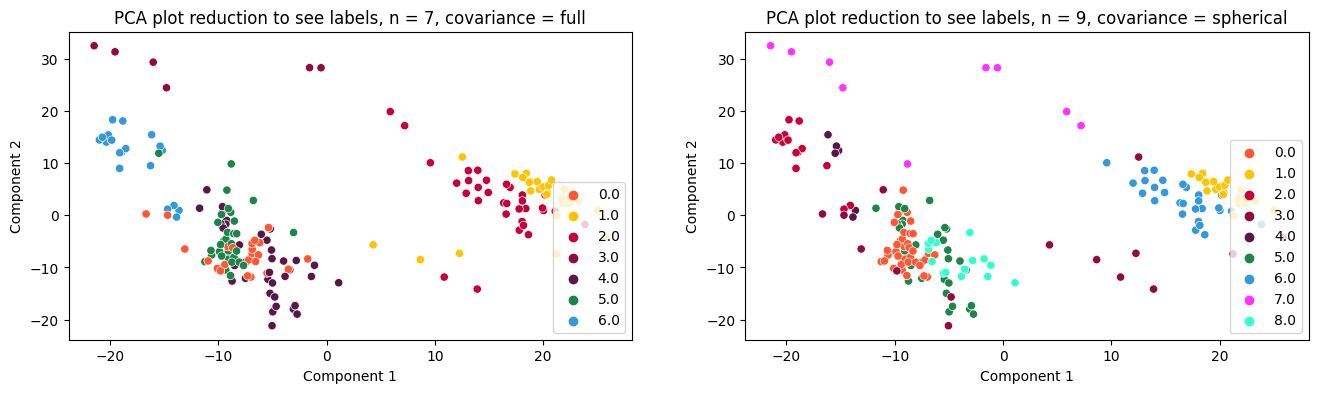

In [199]:
# declaring pca instance to use to plot
pca_plot = PCA(n_components = 2, random_state = 23)

# Creating the X_plot data set
X_plot = pca_plot.fit_transform(X_sc)

# ploting with sns
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig, axis = plt.subplots(1, 2, figsize = (16, 4))

for j in range(2):
    ax = axis[j]
    model = gaussian_models[j]
    X_plot_gauss= np.c_[X_plot, gaussian_labels[j]]
    n_components = len(np.unique(gaussian_labels[j]))
    sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = X_plot_gauss[:, 2], palette = colors[:n_components], ax = ax)
    ax.set_ylabel('Component 2')
    ax.set_xlabel('Component 1')
    ax.set_title(f'PCA plot reduction to see labels, n = {model.n_components}, covariance = {model.covariance_type}')
    ax.legend(loc = 'lower right')
plt.show()

Then it is compared to the actual "y" targets, as first step, a encoding transformation has to be performed before the comparison

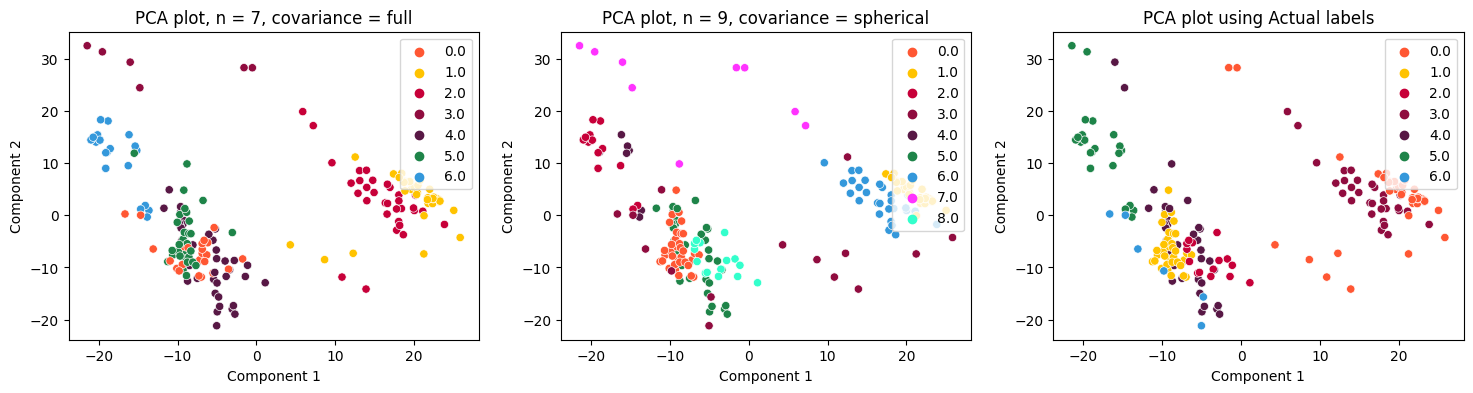

In [206]:
# changing unique values for numeric ones
y_label = np.zeros((len(y),1))
target_dict = dict()
for label, tissue_type in enumerate(np.unique(y)):
    y_label = np.where(y == tissue_type, label, y_label)
    target_dict[label] = tissue_type

y_label = y_label.ravel().astype(int)

# plotting one next to the other
X_plot_real = np.c_[X_plot, y_label]

colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig, axis = plt.subplots(1, 3, figsize = (18, 4))

# first two
for j in range(2):
    ax = axis[j]
    model = gaussian_models[j]
    X_plot_gauss= np.c_[X_plot, gaussian_labels[j]]
    n_components = len(np.unique(gaussian_labels[j]))
    sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = X_plot_gauss[:, 2], palette = colors[:n_components], ax = ax)
    ax.set_ylabel('Component 2')
    ax.set_xlabel('Component 1')
    ax.set_title(f'PCA plot, n = {model.n_components}, covariance = {model.covariance_type}')
    ax.legend(loc = 'upper right')

## third plot
sns.scatterplot(x = X_plot_real[:, 0], y = X_plot_real[:, 1], hue = X_plot_real[:, 2], palette = colors[:7], ax = axis[2])
axis[2].set_ylabel('Component 2')
axis[2].set_xlabel('Component 1')
axis[2].set_title('PCA plot using Actual labels')
axis[2].legend(loc = 'upper right')
plt.show()

By looking at the plots, it can be appreciated some differences, and, based on the fact that class numbers have nothing to do with the gaussian labels inasmuch as the second ones were assigned during the fitting process without having actual labels information. Thus, a check cluster task is performed to visualize the most frequent actual label in each gaussian cluster

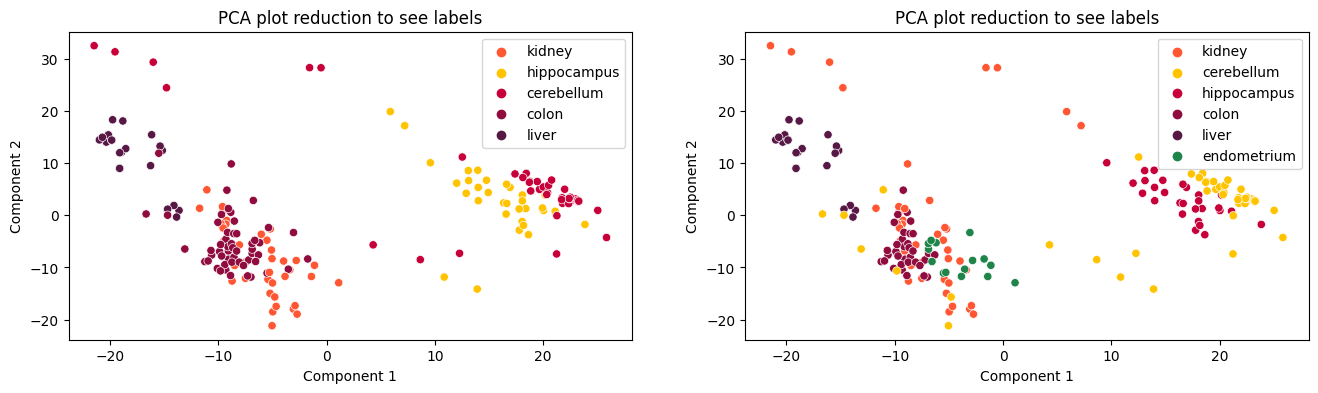

In [214]:
fig, axis = plt.subplots(1, 2, figsize = (16, 4))
# whole dataframe
bases = pd.DataFrame()

for j in range(2):
    # selecting model
    model = gaussian_models[j]

    # Creating a dataframe with gaussian clusters and actual labels
    base_information = {'gaussian_labels': gaussian_labels[j],
                        'actual_labels': y_label,
                        'label_name': y.to_numpy().ravel()}
    
    data_clusters = pd.DataFrame(base_information)

    # creating the X_plot_gauss to visualize
    X_plot_gauss= np.c_[X_plot, gaussian_labels[j]]

    # querying dataframe to verify most frequent label name per gaussian label
    gaussian_dict = data_clusters.groupby('gaussian_labels').agg({'label_name': lambda x: x.mode().iloc[0]}).to_dict()['label_name']
    data_clusters[f'predicted_label_name'] = data_clusters['gaussian_labels'].map(gaussian_dict) # predictions
    data_clusters['n_components'] = model.n_components
    data_clusters['covariance_type'] = model.covariance_type
    n_unique_predicted = len(np.unique(data_clusters['predicted_label_name']))

    # store in big dataframe
    bases = pd.concat([bases, data_clusters], axis = 0, ignore_index = True)
    
    # ploting with sns
    colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
                "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

    ax = axis[j]           
    sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = data_clusters['predicted_label_name'],
                    palette = colors[:n_unique_predicted], ax = ax)
    ax.set_ylabel('Component 2')
    ax.set_xlabel('Component 1')
    ax.set_title('PCA plot reduction to see labels')
    ax.legend(loc = 'upper right')
plt.show()

As it can be seen, gaussian models cannot predict the placenta target by having as a prediction the most frequent class at each gaussian component, afterall, there are other methods to be performed. Now it is time to evaluate recall, precision and f1 score using macro average.

In [217]:
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    base_filter = bases.loc[(bases.covariance_type == covariance_type) & (bases.n_components == n_components)]
    # getting actual values and predictions
    y_actual = base_filter.label_name
    y_pred = base_filter.predicted_label_name

    # getting scores
    recall_gauss = recall_score(y_actual, y_pred, average = 'macro', zero_division = 0)
    precision_gauss = precision_score(y_actual, y_pred, average = 'macro', zero_division = 0)
    f1_gauss = f1_score(y_actual, y_pred, average = 'macro', zero_division = 0)

    # Showing metrics
    print(f'Model: covariance_type = {covariance_type} and n_components = {n_components}')
    print(f"Recall score: {recall_gauss:.4f}")
    print(f"Precision score: {precision_gauss:.4f}")
    print(f"F1 score: {f1_gauss:.4f}\n")

Model: covariance_type = full and n_components = 7
Recall score: 0.6646
Precision score: 0.6116
F1 score: 0.6318

Model: covariance_type = spherical and n_components = 9
Recall score: 0.8258
Precision score: 0.8144
F1 score: 0.8187



In conclusion, from the evaluated models, the one that has the best performance in terms of the predicted labels is the second one, with 9 components and $spherical$ as covariance type